In [1]:
import pickle
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="0.8"

from jax.config import config
#config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm, trange

from itertools import product
import functools
import awkward as ak
import pandas as pd
from hyperion.constants import Constants
from olympus.event_generation.mc_record import MCRecord
from olympus.event_generation.photon_source import PhotonSource, PhotonSourceType
from olympus.event_generation.photon_propagation.norm_flow_photons import make_generate_norm_flow_photons, make_nflow_photon_likelihood_per_module
from olympus.event_generation.photon_propagation.utils import sources_to_model_input_per_module, sources_to_array
from olympus.event_generation.lightyield import make_pointlike_cascade_source, make_realistic_cascade_source

from olympus.optimization.fisher_information import sph_to_cart_jnp

from hyperion.utils import (
    make_cascadia_abs_len_func,
    cherenkov_ang_dist,
    cherenkov_ang_dist_int,
)


from hyperion.pmt.pmt import make_calc_wl_acceptance_weight
from hyperion.medium import cascadia_ref_index_func, sca_len_func_antares
from hyperion.constants import Constants


import jax
from jax import jit, random
from jax import numpy as jnp

%matplotlib inline


In [2]:
ref_index_func = cascadia_ref_index_func
abs_len = make_cascadia_abs_len_func(sca_len_func_antares)

def c_medium_f(wl):
    """Speed of light in medium for wl (nm)."""
    return Constants.BaseConstants.c_vac / cascadia_ref_index_func(wl)

In [3]:
rng = np.random.RandomState(31338)
oms_per_line = 20
dist_z = 50
dark_noise_rate = 16 * 1E4 * 1E-9  # 1/ns

gen_ph = make_generate_norm_flow_photons(
    "data/photon_arrival_time_nflow_params.pickle",
    "data/photon_arrival_time_counts_params.pickle",
   
)

lh_per_mod = (make_nflow_photon_likelihood_per_module(
    "data/photon_arrival_time_nflow_params.pickle",
    "data/photon_arrival_time_counts_params.pickle",
))

lh_per_mod_split = (make_nflow_photon_likelihood_per_module(
    "data/photon_arrival_time_nflow_params.pickle",
    "data/photon_arrival_time_counts_params.pickle",
    split_shape_counts=True
))


evlh = jax.vmap(lh_per_mod, in_axes=[0, 0, None, None, None, None, None, 0])

def eval_for_mod_split(x, y, z, theta, phi, t, log10e, times, mod_coords, noise_rate, key):

    pos = jnp.asarray([x, y, z])
    dir = sph_to_cart_jnp(theta, phi)

    #sources = make_realistic_cascade_source(pos, t, dir, 10**log10e, 11, resolution=0.5, key=key, moliere_rand=True)
    sources = make_pointlike_cascade_source(pos, t, dir, 10**log10e, 11)

    return lh_per_mod_split(
        times,
        mod_coords, sources[0], sources[1], sources[2], sources[3], c_medium_f(700) / 1E9, noise_rate
    )

eval_for_mod_split_jit = jax.jit(eval_for_mod_split)

def eval_for_mod(x, y, z, theta, phi, t, log10e, times, mod_coords, noise_rate, key):

    pos = jnp.asarray([x, y, z])
    dir = sph_to_cart_jnp(theta, phi)

    sources = make_realistic_cascade_source(pos, t, dir, 10**log10e, 11, resolution=0.5, key=key, moliere_rand=True)
    #sources = make_pointlike_cascade_source(pos, t, dir, 10**log10e, 11)

    return lh_per_mod(
        times,
        mod_coords, sources[0], sources[1], sources[2], sources[3], c_medium_f(700) / 1E9, noise_rate
    )




In [27]:
clsim_events, clsim_geo, thetas, phis, _ = pickle.load(open("data/clsim_photons_extracted.pickle", "rb"))
uq_thetas = np.unique(thetas)


In [6]:
clsim_tfirst = []
hyperion_tfirst = []
clsim_amp = []
hyperion_amp = []
omkey = 1
for theta in uq_thetas:
    theta_ix = np.argwhere(thetas == theta).ravel()

    phi = np.asarray(phis)[theta_ix][0]
    if ~np.isfinite(phi):
        phi = 0


    all_times = []
    all_weights = []
    all_ph_thetas = []
    for (times, weights, ph_thetas) in clsim_events:
        all_times.append(times[omkey])
        all_weights.append(weights[omkey])
        all_ph_thetas.append(ph_thetas[omkey])

    all_times = np.asarray(all_times)
    all_weights = np.asarray(all_weights)

    sel_times = np.concatenate(all_times[theta_ix])
    sel_weights = np.concatenate(all_weights[theta_ix])

    tgeo = np.linalg.norm(clsim_geo[omkey] - np.asarray([0, 0, -400])) / c_medium_f(700) * 1E9

    event_data = {"t0": 0., "theta": theta, "phi": phi, "pos": np.asarray([0, 0, -400.]), "energy": 1E5, "pid": 11}
    event_dir = sph_to_cart_jnp(event_data["theta"], event_data["phi"])

    eval_times = jnp.linspace(tgeo - 10, tgeo+50, 60)
    shape_lh, counts_lh, n_pred = eval_for_mod_split(
            event_data["pos"][0], event_data["pos"][1], event_data["pos"][2], theta,
            event_data["phi"], event_data["t0"], jnp.log10(event_data["energy"]),
            eval_times, jnp.asarray(clsim_geo[omkey]), 1E-6, random.PRNGKey(0)
    )
    hyperion_amp.append(n_pred)

    clsim_tfirst.append(np.min(sel_times))
    hyperion_tfirst.append(eval_times[jnp.argmax(shape_lh).ravel()])
    clsim_amp.append(np.sum(sel_weights)/10)




/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


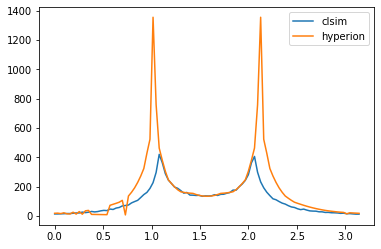

In [7]:
plt.plot(uq_thetas, clsim_amp, label="clsim")
plt.plot(uq_thetas, hyperion_amp, label="hyperion")
plt.legend()

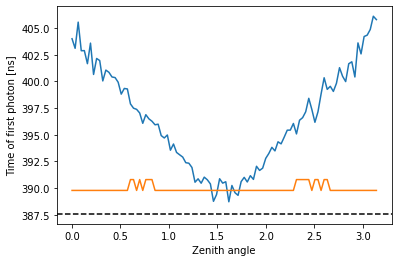

In [8]:
plt.plot(uq_thetas, clsim_tfirst, label="clsim")
plt.plot(uq_thetas, hyperion_tfirst, label="clsim")



plt.ylabel("Time of first photon [ns]")
plt.xlabel("Zenith angle")
plt.axhline(tgeo, color="k", ls="--")

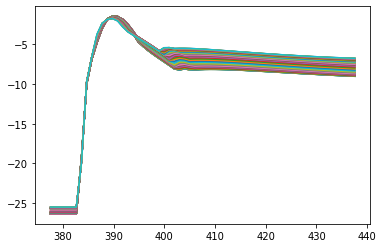

In [9]:
for theta in uq_thetas:
    shape_lh, counts_lh, n_pred = eval_for_mod_split(
            event_data["pos"][0], event_data["pos"][1], event_data["pos"][2], theta,
            event_data["phi"], event_data["t0"], jnp.log10(event_data["energy"]),
            eval_times, jnp.asarray(clsim_geo[omkey]), 1E-6, random.PRNGKey(0)
    )

    plt.plot(eval_times, shape_lh)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"


[]

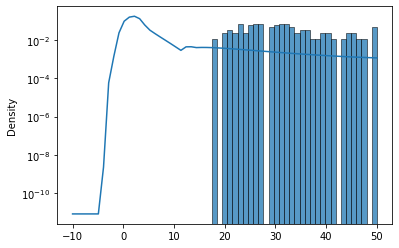

In [10]:
bins = np.linspace(-10, 50, 60)
sns.histplot(x=sel_times - tgeo, weights=sel_weights, bins=bins, stat="density")
plt.plot(eval_times-tgeo, np.exp(shape_lh))
plt.semilogy()

In [11]:
wl_acc = make_calc_wl_acceptance_weight("data/DOMEfficiency.dat")
det_ph = pickle.load(open("data/photon_table_1.pickle", "rb"))[0]


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"


[]

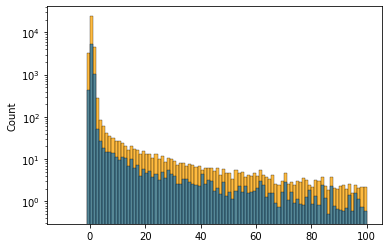

In [12]:
c_medium_f = lambda wl: Constants.BaseConstants.c_vac / cascadia_ref_index_func(wl)

abs_len = make_cascadia_abs_len_func(sca_len_func_antares)
prop_dist = det_ph["times_det"] * c_medium_f(det_ph["wavelengths"])/1E9 
abs_weight = np.exp(-prop_dist / abs_len(det_ph["wavelengths"]))
wl_weight = wl_acc(det_ph["wavelengths"], 0.28)
c_weight = (
                cherenkov_ang_dist(
                    np.cos(det_ph["emission_angles"] - 0), n_ph=cascadia_ref_index_func(det_ph["wavelengths"])
                )
                / cherenkov_ang_dist_int(cascadia_ref_index_func(det_ph["wavelengths"]), -1, 1)
                * 2
            )
total_weight = abs_weight * wl_weight * c_weight

bins = np.linspace(-10, 100, 100)

tres = det_ph["times_det"] - det_ph["dist"] / c_medium_f(700)*1E9
sns.histplot(x=tres, bins = bins, weights=abs_weight, color="orange")
sns.histplot(x=tres, bins = bins, weights=total_weight)

plt.semilogy()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"


[]

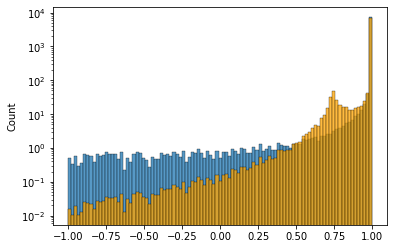

In [26]:
sns.histplot(x=np.cos(det_ph["emission_angles"]), weights= abs_weight * wl_weight, bins=np.linspace(-1, 1, 100))
sns.histplot(x=np.cos(det_ph["emission_angles"]), weights=total_weight, bins=np.linspace(-1, 1, 100), color="orange")
plt.semilogy()

[]

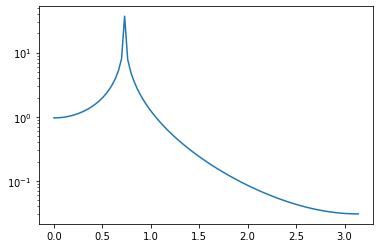

In [22]:
thetas = np.linspace(0, np.pi, 100)
plt.plot(thetas, 
cherenkov_ang_dist(np.cos(thetas - 0), n_ph=cascadia_ref_index_func(700))
                / cherenkov_ang_dist_int(cascadia_ref_index_func(700), -1, 1)
                * 2
)
plt.semilogy()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:385: UserWarning: `bins` cannot be 'auto' when using weights. Setting `bins=10`, but you will likely want to adjust.
  warnings.warn(msg, UserWarning)


10004.636858685975


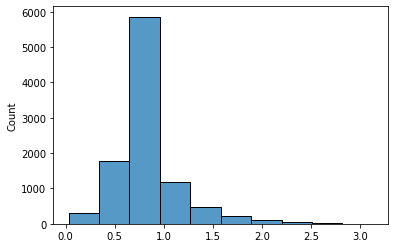

In [20]:
a = np.arccos(np.random.uniform(-1, 1, size=10000))
w = (
    cherenkov_ang_dist(np.cos(a - 0), n_ph=cascadia_ref_index_func(700))
                / cherenkov_ang_dist_int(cascadia_ref_index_func(700), -1, 1)
                * 2)
sns.histplot(x=a, weights=w)

print(np.sum(w))

In [21]:
w

array([0.11430867, 1.28567841, 0.51839896, ..., 0.06136814, 0.07209044,
       0.19610162])

<AxesSubplot:ylabel='Count'>

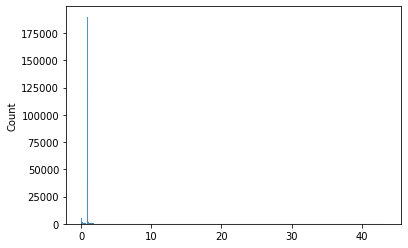

In [14]:
sns.histplot(c_weight, bins=1000)